# Part A: Train on cifar-10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms
import torchvision.models as models

import json
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import time

In [ ]:
# preprocessing pipeline for input images
transformation = dict()
for data_type in ("train", "test"):
    is_train = data_type=="train"
    transformation[data_type] = tv_transforms.Compose(([
        # tv_transforms.Resize(224), ## resize to fit in resnet18
        tv_transforms.RandomRotation(degrees=15),
        tv_transforms.RandomHorizontalFlip(),
        tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ] if is_train else []) +
    [
        tv_transforms.ToTensor(),
        tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

transformation_aug = dict()
for data_type in ("train", "test"):
    is_train = data_type=="train"
    transformation_aug[data_type] = tv_transforms.Compose(([
        # tv_transforms.Resize(224), ## resize to fit in resnet18
        tv_transforms.RandomHorizontalFlip(),
        tv_transforms.RandomCrop(32, padding=2),
        tv_transforms.RandomRotation(degrees=15),
        tv_transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        tv_transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.1)
    ] if is_train else []) +
    [
        tv_transforms.ToTensor(),
        tv_transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])

# training parameter
num_epochs = 128         
batch_size = 64
num_workers = 2
print_every = 200

In [3]:
# prepare datasets
dataset, loader = {}, {}
for data_type in ("train", "test"):
    is_train = data_type=="train"
    dataset[data_type] = tv_datasets.CIFAR10(
        # root="./data", train=is_train, download=True, transform=transformation[data_type],
        ## with data augmentation
        root="./data", train=is_train, download=True, transform=transformation_aug[data_type],
    )
    loader[data_type] = torch.utils.data.DataLoader(
        dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )
class_names = dataset["train"].classes
print(class_names)
print(os.listdir())


100%|██████████| 170M/170M [00:02<00:00, 62.8MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['.virtual_documents', 'data']


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU.")
else:
    print("Using CPU.")

Using GPU.


**TRY: MY STEPS TO INCREASE ACCURACY**
1. Reproduce original net
2. Add batchnorm layer to the original network 
3. Make the network in 2. deeper and wider
4. Use better optimizer (AdamW, SGD+momentum) based on 3.
5. Use data augmentation based on 4.
(6. Complicate net but high accuracy; dump)

In [ ]:
## orignal net
origin_net = nn.Sequential(
    nn.Conv2d(3, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
    nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
    nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
    nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
    nn.Flatten(),
    nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(128, 10),
)

## orginal net + add batchnorm layers
ab_net = nn.Sequential(
    nn.Conv2d(3, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
    nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
    nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
    nn.Conv2d(512, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
    nn.Flatten(),
    nn.Linear(256 * 4 * 4, 512), nn.BatchNorm1d(512), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(128, 10),
)


## modified net
new_net = nn.Sequential(
    nn.Conv2d(3, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
    nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
    nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),nn.MaxPool2d(2), nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(512 * 4 * 4, 512), nn.BatchNorm1d(512), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(256, 10),
)


In [6]:
# the network optimizer
optim_adam = "Adam"
adam_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-6,
)
optim_adamw = "AdamW"
adamw_kwargs = dict(
    lr=1e-3,
    weight_decay=1e-3,
)
optim_sgd = "SGD"
sgd_kwargs = dict(
    lr=1e-2,
    momentum = 0.9,
    weight_decay=1e-5,
)

In [7]:
# training loop function

def training_loop(net, optimizer, name, scheduler = None):

    net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    
    # training loop
    net.train()
    for epoch in range(num_epochs):
        total_epoch_loss = 0.0
        running_loss = 0.0
        correct_train, total_train = 0,0
        for i, (img, target) in enumerate(loader["train"]):
            img, target = img.to(device), target.to(device)

            pred = net(img)
            loss = criterion(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train += len(target)
            correct_train += (torch.argmax(pred, dim=1) == target).sum().item()
            total_epoch_loss += loss.item()
            if i % print_every == print_every - 1:
                print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
                running_loss = 0.0
                
        epoch_loss = total_epoch_loss / len(loader["train"])
        print(f"epoch {epoch + 1} loss:{epoch_loss}")
        
        if optimizer.__class__.__name__ == "AdamW":# or optimizer.__class__.__name__ == "SGD": 
            scheduler.step()
        
        train_losses.append(epoch_loss)
        train_accuracies.append(100 * correct_train / total_train)

    print(f"{name}: Finished Training")

    ## saving results to json
    file_name = f"training_result_{name}.json"
    new_data = {name:{
            "train_losses": train_losses,
            "train_accuracies": train_accuracies
            }
        }  
    try:
        with open(file_name, "r") as f:
            data = json.load(f) 
    except (FileNotFoundError, json.JSONDecodeError):  
        data = {}  

    data.update(new_data)

    with open(file_name, "w") as f:
        json.dump(data, f, indent=4)
    print(f"Training results have been saved.")
    # print("training_result: ",data)

    return net


In [8]:
# test evaluation
def eval_metric(net,name):
    net.eval()
    y_true, y_pred = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for img, target in loader["test"]:
            img, target = img.to(device), target.to(device)

            pred = net(img)
            y_true.extend(target.cpu().numpy().tolist())
            y_pred.extend(torch.argmax(pred, dim=1).cpu().numpy().tolist())
            total += len(target)
            correct += (torch.argmax(pred, dim=1) == target).sum().item()

    print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

    ## saving results to json
    file_name = f"eval_result_{name}.json"
    new_data = {name:{
            "y_true": y_true,
            "y_pred": y_pred,
            "acc": f"{100 * correct / total:.2f}"
            }
        }  
    try:
        with open(file_name, "r") as f:
            data = json.load(f) 
    except (FileNotFoundError, json.JSONDecodeError):  
        data = {}  

    data.update(new_data)

    with open(file_name, "w") as f:
        json.dump(data, f, indent=4)
    print(f"Evaluation results on test data have been saved.")
    # print("eval_result: ",data)
    

**1. Reproduce original code**

In [9]:
ad_optimizer = getattr(optim, optim_adam)(origin_net.parameters(), **adam_kwargs)
print(f"number of parameters for original net: {sum(p.numel() for p in origin_net.parameters() if p.requires_grad) / 1_000_000:.2f}M")
start_time = time.time()
trained_orig_net = training_loop(origin_net, ad_optimizer, "orig")
end_time = time.time()
print("cost time: ", end_time-start_time)
eval_metric(trained_orig_net,"orig")

number of parameters for original net: 7.28M
[epoch=  1, iter=  200] loss: 2.217
[epoch=  1, iter=  400] loss: 1.980
[epoch=  1, iter=  600] loss: 1.868
epoch 1 loss:1.9665256417011057
[epoch=  2, iter=  200] loss: 1.699
[epoch=  2, iter=  400] loss: 1.615
[epoch=  2, iter=  600] loss: 1.547
epoch 2 loss:1.589897542810806
[epoch=  3, iter=  200] loss: 1.460
[epoch=  3, iter=  400] loss: 1.422
[epoch=  3, iter=  600] loss: 1.375
epoch 3 loss:1.3973036593640857
[epoch=  4, iter=  200] loss: 1.314
[epoch=  4, iter=  400] loss: 1.266
[epoch=  4, iter=  600] loss: 1.246
epoch 4 loss:1.26659803713679
[epoch=  5, iter=  200] loss: 1.187
[epoch=  5, iter=  400] loss: 1.178
[epoch=  5, iter=  600] loss: 1.138
epoch 5 loss:1.1605576867490168
[epoch=  6, iter=  200] loss: 1.092
[epoch=  6, iter=  400] loss: 1.087
[epoch=  6, iter=  600] loss: 1.067
epoch 6 loss:1.0715593309963451
[epoch=  7, iter=  200] loss: 1.014
[epoch=  7, iter=  400] loss: 0.995
[epoch=  7, iter=  600] loss: 1.011
epoch 7 lo

**2. Regulization: add batchnorm layer**

In [13]:
for layer in ab_net.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
        
ab_optimizer = getattr(optim, optim_adam)(ab_net.parameters(), **adam_kwargs)
print(f"number of parameters for original net with batchnorm: {sum(p.numel() for p in ab_net.parameters() if p.requires_grad) / 1_000_000:.2f}M")
start_time = time.time()
trained_ab_net = training_loop(ab_net, ab_optimizer, "orig_ab")
end_time = time.time()
print("cost time: ", end_time-start_time)
eval_metric(trained_ab_net,"orig_ab")

number of parameters for original net with batchnorm: 7.29M
[epoch=  1, iter=  200] loss: 2.105
[epoch=  1, iter=  400] loss: 1.797
[epoch=  1, iter=  600] loss: 1.641
epoch 1 loss:1.773439618785058
[epoch=  2, iter=  200] loss: 1.456
[epoch=  2, iter=  400] loss: 1.381
[epoch=  2, iter=  600] loss: 1.336
epoch 2 loss:1.3635821577990452
[epoch=  3, iter=  200] loss: 1.259
[epoch=  3, iter=  400] loss: 1.207
[epoch=  3, iter=  600] loss: 1.164
epoch 3 loss:1.1923689205018455
[epoch=  4, iter=  200] loss: 1.090
[epoch=  4, iter=  400] loss: 1.072
[epoch=  4, iter=  600] loss: 1.062
epoch 4 loss:1.0664127222869708
[epoch=  5, iter=  200] loss: 1.033
[epoch=  5, iter=  400] loss: 0.992
[epoch=  5, iter=  600] loss: 0.965
epoch 5 loss:0.9893487700263558
[epoch=  6, iter=  200] loss: 0.956
[epoch=  6, iter=  400] loss: 0.929
[epoch=  6, iter=  600] loss: 0.916
epoch 6 loss:0.9219279535438704
[epoch=  7, iter=  200] loss: 0.895
[epoch=  7, iter=  400] loss: 0.875
[epoch=  7, iter=  600] loss:

**3. Make the old net wider with batchnorm layer**

In [14]:
adam_optimizer = getattr(optim, optim_adam)(new_net.parameters(), **adam_kwargs)
print(f"number of parameters for new net: {sum(p.numel() for p in new_net.parameters() if p.requires_grad) / 1_000_000:.2f}M")
start_time = time.time()
trained_new_net = training_loop(new_net, adam_optimizer, "new_net")
end_time = time.time()
print("cost time: ", end_time-start_time)
eval_metric(trained_new_net,"new_net")

number of parameters for new net: 8.76M
[epoch=  1, iter=  200] loss: 1.865
[epoch=  1, iter=  400] loss: 1.549
[epoch=  1, iter=  600] loss: 1.416
epoch 1 loss:1.5393326752021184
[epoch=  2, iter=  200] loss: 1.236
[epoch=  2, iter=  400] loss: 1.176
[epoch=  2, iter=  600] loss: 1.119
epoch 2 loss:1.153933719905746
[epoch=  3, iter=  200] loss: 1.026
[epoch=  3, iter=  400] loss: 1.014
[epoch=  3, iter=  600] loss: 0.982
epoch 3 loss:0.9962111425674175
[epoch=  4, iter=  200] loss: 0.920
[epoch=  4, iter=  400] loss: 0.911
[epoch=  4, iter=  600] loss: 0.914
epoch 4 loss:0.9084212199958694
[epoch=  5, iter=  200] loss: 0.849
[epoch=  5, iter=  400] loss: 0.843
[epoch=  5, iter=  600] loss: 0.841
epoch 5 loss:0.8420054827199872
[epoch=  6, iter=  200] loss: 0.797
[epoch=  6, iter=  400] loss: 0.810
[epoch=  6, iter=  600] loss: 0.776
epoch 6 loss:0.7870950727054226
[epoch=  7, iter=  200] loss: 0.755
[epoch=  7, iter=  400] loss: 0.744
[epoch=  7, iter=  600] loss: 0.759
epoch 7 loss:

**4.1 New net with AdamW optimizer**

In [15]:
# reset parameter
for layer in new_net.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
        
adamw_optimizer = getattr(optim, optim_adamw)(new_net.parameters(), **adamw_kwargs)
scheduler = optim.lr_scheduler.CosineAnnealingLR(adamw_optimizer, T_max=50, eta_min=1e-6)
print(f"number of parameters for net: {sum(p.numel() for p in new_net.parameters() if p.requires_grad) / 1_000_000:.2f}M")
start_time = time.time()
trained_new_net_adamw = training_loop(new_net, adamw_optimizer, "new_net_adamw",scheduler=scheduler)
end_time = time.time()
print("cost time: ", end_time-start_time)
eval_metric(trained_new_net_adamw,"new_net_adamw")

number of parameters for net: 8.76M
[epoch=  1, iter=  200] loss: 1.773
[epoch=  1, iter=  400] loss: 1.483
[epoch=  1, iter=  600] loss: 1.372
epoch 1 loss:1.4801991206148397
[epoch=  2, iter=  200] loss: 1.211
[epoch=  2, iter=  400] loss: 1.157
[epoch=  2, iter=  600] loss: 1.099
epoch 2 loss:1.131703451237715
[epoch=  3, iter=  200] loss: 1.020
[epoch=  3, iter=  400] loss: 0.974
[epoch=  3, iter=  600] loss: 0.969
epoch 3 loss:0.9761495286851283
[epoch=  4, iter=  200] loss: 0.909
[epoch=  4, iter=  400] loss: 0.893
[epoch=  4, iter=  600] loss: 0.866
epoch 4 loss:0.8807462908499076
[epoch=  5, iter=  200] loss: 0.836
[epoch=  5, iter=  400] loss: 0.828
[epoch=  5, iter=  600] loss: 0.802
epoch 5 loss:0.81691426229294
[epoch=  6, iter=  200] loss: 0.767
[epoch=  6, iter=  400] loss: 0.759
[epoch=  6, iter=  600] loss: 0.738
epoch 6 loss:0.7513629433977634
[epoch=  7, iter=  200] loss: 0.724
[epoch=  7, iter=  400] loss: 0.698
[epoch=  7, iter=  600] loss: 0.706
epoch 7 loss:0.7088

**4.2 New net with SGD**

In [17]:
# reset parameter
for layer in new_net.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
        
sgd_optimizer = getattr(optim, optim_sgd)(new_net.parameters(), **sgd_kwargs)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(adamw_optimizer, T_max=50, eta_min=1e-6)
print(f"number of parameters for net: {sum(p.numel() for p in new_net.parameters() if p.requires_grad) / 1_000_000:.2f}M")
start_time = time.time()
trained_new_net_sgd = training_loop(new_net, sgd_optimizer, "new_net_sgd")##,scheduler)
end_time = time.time()
print("cost time: ", end_time-start_time)
eval_metric(trained_new_net_sgd,"new_net_sgd")

number of parameters for net: 8.76M
[epoch=  1, iter=  200] loss: 1.885
[epoch=  1, iter=  400] loss: 1.587
[epoch=  1, iter=  600] loss: 1.480
epoch 1 loss:1.5909501202880878
[epoch=  2, iter=  200] loss: 1.326
[epoch=  2, iter=  400] loss: 1.270
[epoch=  2, iter=  600] loss: 1.191
epoch 2 loss:1.244862447995359
[epoch=  3, iter=  200] loss: 1.146
[epoch=  3, iter=  400] loss: 1.107
[epoch=  3, iter=  600] loss: 1.069
epoch 3 loss:1.0886945389115903
[epoch=  4, iter=  200] loss: 1.032
[epoch=  4, iter=  400] loss: 0.980
[epoch=  4, iter=  600] loss: 0.972
epoch 4 loss:0.984692496945486
[epoch=  5, iter=  200] loss: 0.934
[epoch=  5, iter=  400] loss: 0.912
[epoch=  5, iter=  600] loss: 0.902
epoch 5 loss:0.9065572232617747
[epoch=  6, iter=  200] loss: 0.858
[epoch=  6, iter=  400] loss: 0.858
[epoch=  6, iter=  600] loss: 0.866
epoch 6 loss:0.8562033575818971
[epoch=  7, iter=  200] loss: 0.822
[epoch=  7, iter=  400] loss: 0.822
[epoch=  7, iter=  600] loss: 0.816
epoch 7 loss:0.817

 **5.1 Use data augmentation (Adam optim)**

In [1]:
# reset parameter
for layer in new_net.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

aug_optimizer = getattr(optim, optim_adam)(new_net.parameters(), **adam_kwargs)
print(f"number of parameters for new net: {sum(p.numel() for p in new_net.parameters() if p.requires_grad) / 1_000_000:.2f}M")
start_time = time.time()
trained_new_net = training_loop(new_net, aug_optimizer, "aug_new_net")
end_time = time.time()
print("cost time: ", end_time-start_time)
eval_metric(trained_new_net,"aug_new_net")

number of parameters for new net: 8.76M
[epoch=  1, iter=  200] loss: 1.969
[epoch=  1, iter=  400] loss: 1.670
[epoch=  1, iter=  600] loss: 1.515
epoch 1 loss:1.6524182497083073
[epoch=  2, iter=  200] loss: 1.365
[epoch=  2, iter=  400] loss: 1.299
[epoch=  2, iter=  600] loss: 1.272
epoch 2 loss:1.2880815240885595
[epoch=  3, iter=  200] loss: 1.182
[epoch=  3, iter=  400] loss: 1.150
[epoch=  3, iter=  600] loss: 1.134
epoch 3 loss:1.1426393728122077
[epoch=  4, iter=  200] loss: 1.077
[epoch=  4, iter=  400] loss: 1.060
[epoch=  4, iter=  600] loss: 1.043
epoch 4 loss:1.05100350710742
[epoch=  5, iter=  200] loss: 1.003
[epoch=  5, iter=  400] loss: 0.998
[epoch=  5, iter=  600] loss: 0.973
epoch 5 loss:0.9881477718767913
[epoch=  6, iter=  200] loss: 0.928
[epoch=  6, iter=  400] loss: 0.939
[epoch=  6, iter=  600] loss: 0.936
epoch 6 loss:0.9332060511307338
[epoch=  7, iter=  200] loss: 0.914
[epoch=  7, iter=  400] loss: 0.891
[epoch=  7, iter=  600] loss: 0.887
epoch 7 loss:0

 **5.2 Use data augmentation (AdamW optim)**

In [14]:
# reset parameter
for layer in new_net.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

augW_optimizer = getattr(optim, optim_adamw)(new_net.parameters(), **adamw_kwargs)
scheduler = optim.lr_scheduler.CosineAnnealingLR(augW_optimizer, T_max=50, eta_min=1e-6)
print(f"number of parameters for new net: {sum(p.numel() for p in new_net.parameters() if p.requires_grad) / 1_000_000:.2f}M")
start_time = time.time()
trained_new_net = training_loop(new_net, augW_optimizer, "aug_new_net_adamw",scheduler)
end_time = time.time()
print("cost time: ", end_time-start_time)
eval_metric(trained_new_net,"aug_new_net_adamw")

number of parameters for new net: 8.76M
[epoch=  1, iter=  200] loss: 1.880
[epoch=  1, iter=  400] loss: 1.584
[epoch=  1, iter=  600] loss: 1.490
epoch 1 loss:1.5941500909188215
[epoch=  2, iter=  200] loss: 1.337
[epoch=  2, iter=  400] loss: 1.284
[epoch=  2, iter=  600] loss: 1.254
epoch 2 loss:1.2715731145780715
[epoch=  3, iter=  200] loss: 1.192
[epoch=  3, iter=  400] loss: 1.123
[epoch=  3, iter=  600] loss: 1.099
epoch 3 loss:1.128419670531207
[epoch=  4, iter=  200] loss: 1.062
[epoch=  4, iter=  400] loss: 1.053
[epoch=  4, iter=  600] loss: 1.016
epoch 4 loss:1.0382499888424983
[epoch=  5, iter=  200] loss: 0.973
[epoch=  5, iter=  400] loss: 0.957
[epoch=  5, iter=  600] loss: 0.957
epoch 5 loss:0.9559615252115538
[epoch=  6, iter=  200] loss: 0.926
[epoch=  6, iter=  400] loss: 0.906
[epoch=  6, iter=  600] loss: 0.911
epoch 6 loss:0.9070808320399135
[epoch=  7, iter=  200] loss: 0.870
[epoch=  7, iter=  400] loss: 0.874
[epoch=  7, iter=  600] loss: 0.849
epoch 7 loss:

 **5.3 Use data augmentation (SGD optim)**

In [9]:
# reset parameter
for layer in new_net.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

augSGD_optimizer = getattr(optim, optim_sgd)(new_net.parameters(), **sgd_kwargs)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(augSGD_optimizer, T_max=50, eta_min=1e-6)
print(f"number of parameters for new net: {sum(p.numel() for p in new_net.parameters() if p.requires_grad) / 1_000_000:.2f}M")
start_time = time.time()
trained_new_net = training_loop(new_net, augSGD_optimizer, "aug_new_net_sgd")#, scheduler)
end_time = time.time()
print("cost time: ", end_time-start_time)
eval_metric(trained_new_net,"aug_new_net_sgd")

number of parameters for new net: 8.76M
[epoch=  1, iter=  200] loss: 1.976
[epoch=  1, iter=  400] loss: 1.720
[epoch=  1, iter=  600] loss: 1.610
epoch 1 loss:1.713401077958324
[epoch=  2, iter=  200] loss: 1.467
[epoch=  2, iter=  400] loss: 1.420
[epoch=  2, iter=  600] loss: 1.357
epoch 2 loss:1.39354654376769
[epoch=  3, iter=  200] loss: 1.292
[epoch=  3, iter=  400] loss: 1.268
[epoch=  3, iter=  600] loss: 1.225
epoch 3 loss:1.250302926811111
[epoch=  4, iter=  200] loss: 1.176
[epoch=  4, iter=  400] loss: 1.137
[epoch=  4, iter=  600] loss: 1.117
epoch 4 loss:1.1383617236028851
[epoch=  5, iter=  200] loss: 1.089
[epoch=  5, iter=  400] loss: 1.073
[epoch=  5, iter=  600] loss: 1.066
epoch 5 loss:1.0666217890084553
[epoch=  6, iter=  200] loss: 1.017
[epoch=  6, iter=  400] loss: 1.021
[epoch=  6, iter=  600] loss: 1.006
epoch 6 loss:1.0120052267675814
[epoch=  7, iter=  200] loss: 0.996
[epoch=  7, iter=  400] loss: 0.977
[epoch=  7, iter=  600] loss: 0.962
epoch 7 loss:0.9

**6. Experiments of more complex net**

In [ ]:
net = nn.Sequential(
    nn.Conv2d(3, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
    nn.MaxPool2d(2), nn.Dropout(0.3),
    nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
    nn.MaxPool2d(2), nn.Dropout(0.4),
    nn.Conv2d(512, 1024, 3, padding=1), nn.BatchNorm2d(1024), nn.ReLU(inplace=True),
    nn.MaxPool2d(2), nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(1024 * 4 * 4, 1024), nn.BatchNorm1d(1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True), nn.Dropout(0.5),
    nn.Linear(256, 10),
)
adam_optimizer = getattr(optim, optim_adam)(net.parameters(), **adam_kwargs)
print(f"number of parameters for new net: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")
start_time = time.time()
trained_new_net = training_loop(net, adam_optimizer, "complex_net")
end_time = time.time()
print("cost time: ", end_time-start_time)
eval_metric(trained_new_net,"complex_net")

number of parameters for new net: 35.74M
[epoch=  1, iter=  200] loss: 1.945
[epoch=  1, iter=  400] loss: 1.597
[epoch=  1, iter=  600] loss: 1.433
epoch 1 loss:1.5819223309721788
[epoch=  2, iter=  200] loss: 1.224
[epoch=  2, iter=  400] loss: 1.178
[epoch=  2, iter=  600] loss: 1.101
epoch 2 loss:1.1395412412903192
[epoch=  3, iter=  200] loss: 0.995
[epoch=  3, iter=  400] loss: 0.956
[epoch=  3, iter=  600] loss: 0.935
epoch 3 loss:0.9458818848023329
[epoch=  4, iter=  200] loss: 0.871
[epoch=  4, iter=  400] loss: 0.868
[epoch=  4, iter=  600] loss: 0.846
epoch 4 loss:0.8532923393313537
[epoch=  5, iter=  200] loss: 0.787
[epoch=  5, iter=  400] loss: 0.768
[epoch=  5, iter=  600] loss: 0.777
epoch 5 loss:0.7718738485937533
[epoch=  6, iter=  200] loss: 0.736
[epoch=  6, iter=  400] loss: 0.724
[epoch=  6, iter=  600] loss: 0.697
epoch 6 loss:0.7142512430544095
[epoch=  7, iter=  200] loss: 0.698
[epoch=  7, iter=  400] loss: 0.663
[epoch=  7, iter=  600] loss: 0.665
epoch 7 los

# Visualization

In [148]:
def visualize_result(train_file_name, eval_file_name, train_aug=None, eval_aug=None):
    with open(train_file_name, "r") as f:
        train = json.load(f)
    trn = list(train.values())[0]
    train_losses = trn["train_losses"]
    train_accuracies = trn["train_accuracies"]

    if train_aug is None:
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
    else:
        plt.figure(figsize=(11, 8))
        plt.subplot(221) 

    plt.plot(np.arange(128) + 1, train_losses, label="Original")
    if train_aug is not None:
        with open(train_aug, "r") as f:
            train_aug_data = json.load(f)
        trn_aug = list(train_aug_data.values())[0]
        aug_losses = trn_aug["train_losses"]
        aug_accuracies = trn_aug["train_accuracies"]
        plt.plot(np.arange(128) + 1, aug_losses, label="Augmented")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid()


    if train_aug is None:
        plt.subplot(132) 
    else:
        plt.subplot(222) 
    plt.plot(np.arange(128) + 1, train_accuracies, label="Original")
    if train_aug is not None:
        plt.plot(np.arange(128) + 1, aug_accuracies, label="Augmented")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy Curve")
    plt.legend()
    plt.grid()

    with open(eval_file_name, "r") as f:
        test = json.load(f)
    tst = list(test.values())[0]
    y_pred = tst["y_pred"]
    y_true = tst["y_true"]
    conf_matrix = sk.confusion_matrix(y_true=y_true, y_pred=y_pred)

    if eval_aug is None:
        plt.subplot(133)
    else:
        plt.subplot(223)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Original)")

    if eval_aug is not None:
        with open(eval_aug, "r") as f:
            test_aug = json.load(f)
        tst_aug = list(test_aug.values())[0]
        y_pred_aug = tst_aug["y_pred"]
        y_true_aug = tst_aug["y_true"]
        conf_matrix_aug = sk.confusion_matrix(y_true=y_true_aug, y_pred=y_pred_aug)
        plt.subplot(224)
        sns.heatmap(conf_matrix_aug, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix (Augmented)")

    plt.tight_layout() 
    plt.show()

    # print(sk.classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]), end = " ")
    print(f"Accuracy of the network {tst['acc']}%")

    if eval_aug is not None:
        # print(sk.classification_report(y_true_aug, y_pred_aug, target_names=[str(i) for i in range(10)]))
        print(f"Accuracy of the network with data augmentation {tst_aug['acc']}%")
        return train_losses, train_accuracies, tst["acc"], aug_losses, aug_accuracies, tst_aug["acc"]
    else:
        return train_losses, train_accuracies, tst["acc"]
    
gather_loss, gather_accuracy, test_acc = {},{},{}

**Original net**

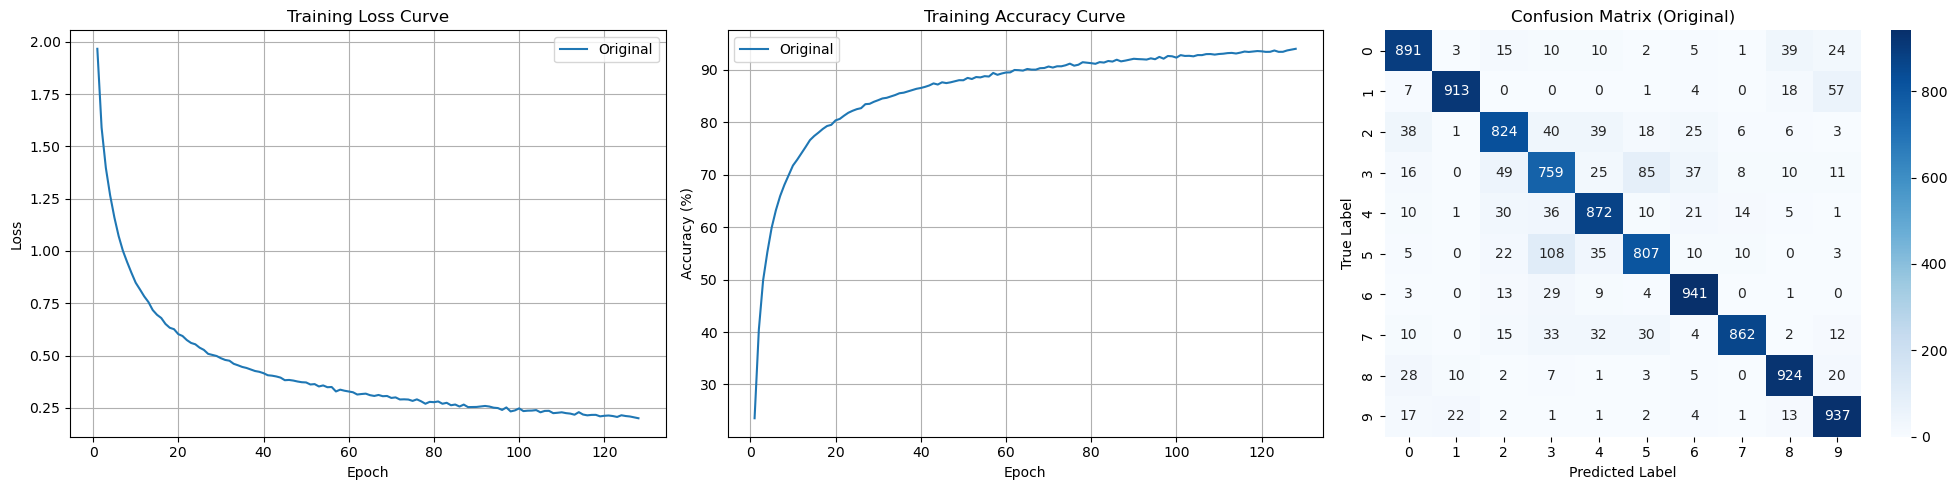

Accuracy of the network 87.30%


In [149]:
tl, ta, ac = visualize_result('training_result_orig.json', 'eval_result_orig.json')
gather_loss["orig_net"] = tl
gather_accuracy["orig_net"] = ta
test_acc["orig_net"] = ac

**old net + batchnorm layer**

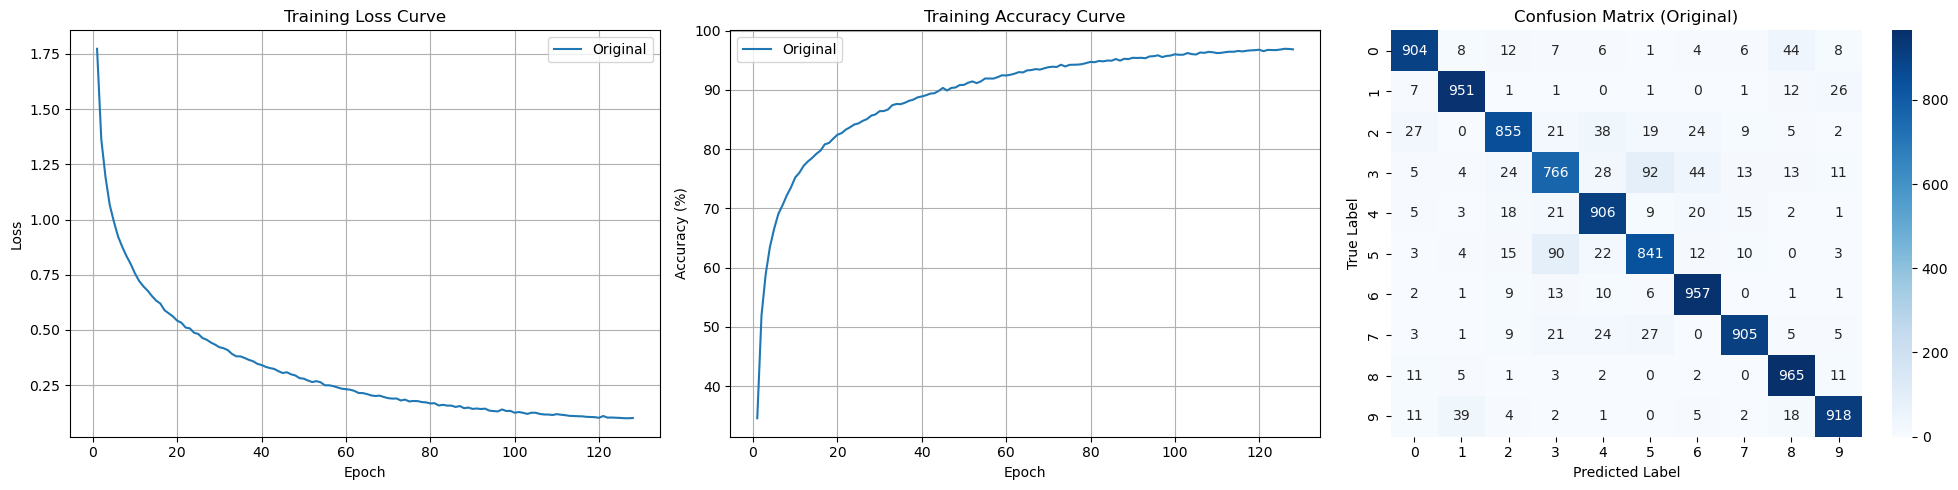

Accuracy of the network 89.68%


In [150]:
tl, ta, ac = visualize_result('training_result_orig_ab.json', 'eval_result_orig_ab.json')
gather_loss["orig_net_ab"] = tl
gather_accuracy["orig_net_ab"] = ta
test_acc["orig_net_ab"] = ac

**new net (with modification of the previous one) with Adam**

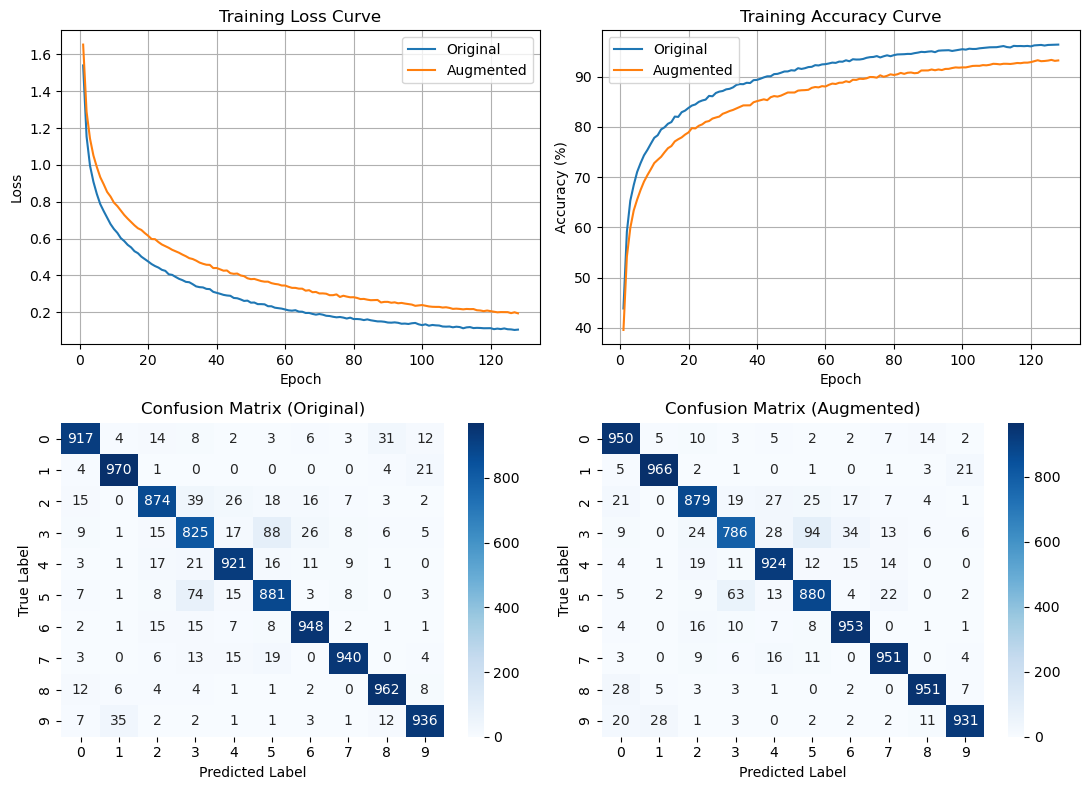

Accuracy of the network 91.74%
Accuracy of the network with data augmentation 91.71%


In [151]:
tl, ta, ac, tla, taa, aca = visualize_result('training_result_new_net.json', 'eval_result_new_net.json', "training_result_aug_new_net.json",'eval_result_aug_new_net.json')
gather_loss["new_net"] = tl
gather_accuracy["new_net"] = ta
test_acc["new_net"] = ac
gather_loss["new_net(aug)"] = tla
gather_accuracy["new_net(aug)"] = taa
test_acc["new_net(aug)"] = aca

**new net with AdamW**

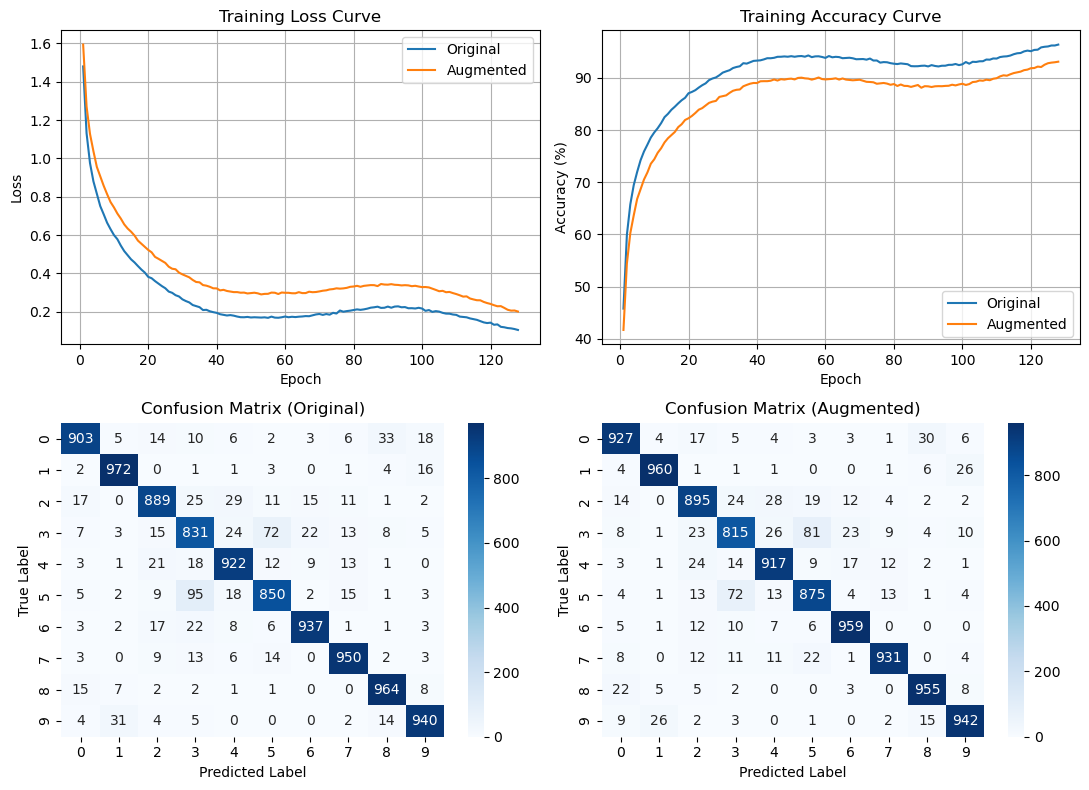

Accuracy of the network 91.58%
Accuracy of the network with data augmentation 91.76%


In [152]:
tl, ta, ac, tla, taa, aca = visualize_result('training_result_new_net_adamw.json', 'eval_result_new_net_adamw.json','training_result_aug_new_net_adamw.json', 'eval_result_aug_new_net_adamw.json')
gather_loss["new_net+AdamW"] = tl
gather_accuracy["new_net+AdamW"] = ta
test_acc["new_net+AdamW"] = ac
gather_loss["new_net+AdamW(aug)"] = tla
gather_accuracy["new_net+AdamW(aug)"] = taa
test_acc["new_net+AdamW(aug)"] = aca

**new net with SGD with momentum**

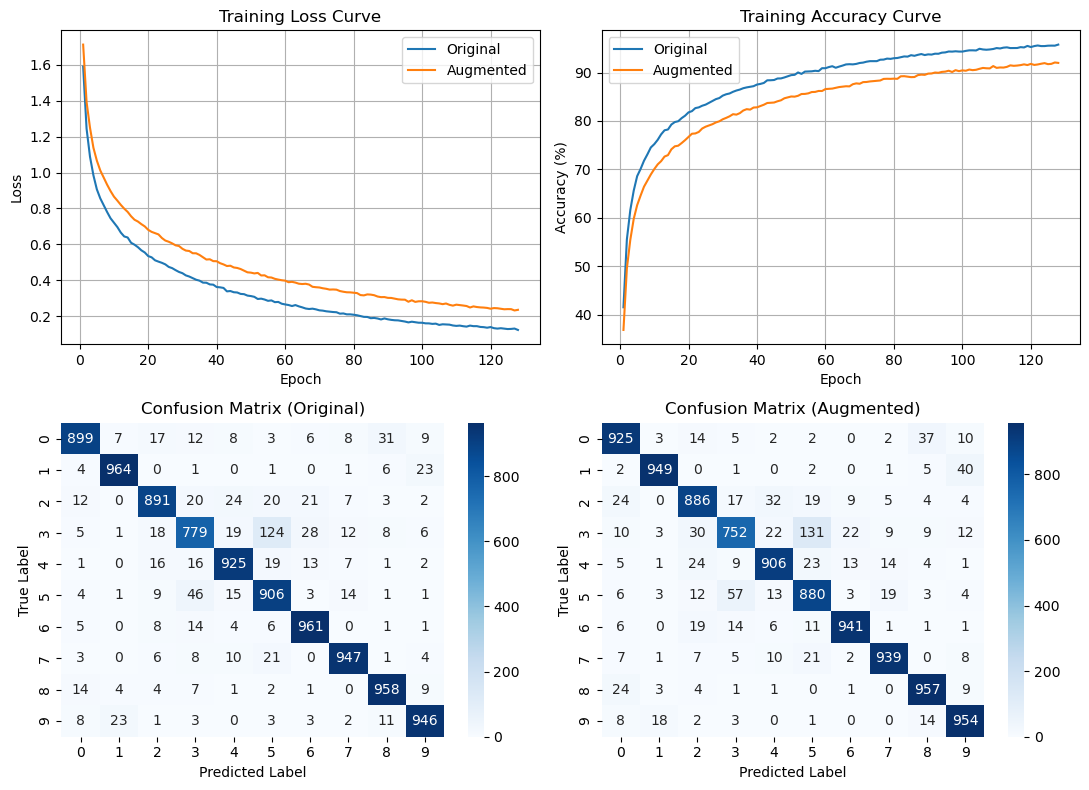

Accuracy of the network 91.76%
Accuracy of the network with data augmentation 90.89%


In [153]:
tl, ta, ac,tla, taa, aca = visualize_result('training_result_new_net_sgd.json', 'eval_result_new_net_sgd.json','training_result_aug_new_net_sgd.json', 'eval_result_aug_new_net_sgd.json')
gather_loss["new_net+SGD"] = tl
gather_accuracy["new_net+SGD"] = ta
test_acc["new_net+SGD"] = ac
gather_loss["new_net+SGD(aug)"] = tla
gather_accuracy["new_net+SGD(aug)"] = taa
test_acc["new_net+SGD(aug)"] = aca

**(Attempt with complex net)**

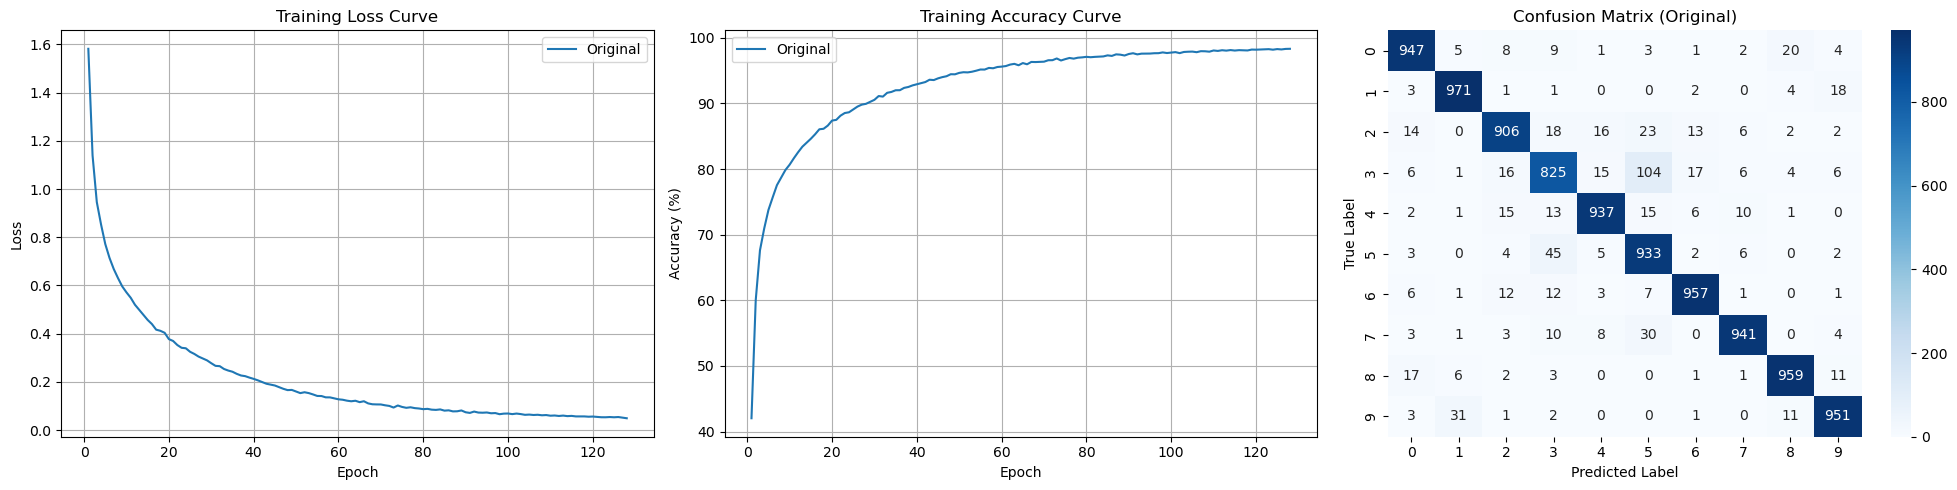

Accuracy of the network 93.27%


In [154]:
tl, ta, ac = visualize_result('training_result_complex_net.json', 'eval_result_complex_net.json')
gather_loss["complex_net"] = tl
gather_accuracy["complex_net"] = ta
test_acc["complex_net"] = ac

In [183]:
def plot_train(key):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    for i in range(len(key)):
        plt.plot(np.arange(128)+1, gather_loss[key[i]],label = key[i],alpha = 0.7)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid()
    plt.legend()
    plt.subplot(122)
    for i in range(len(key)):
        plt.plot(np.arange(128)+1, gather_accuracy[key[i]],label = key[i],alpha = 0.7)
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.title("Training Accuracy Curve")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

keys = list(gather_loss.keys())
print(keys)



['orig_net', 'orig_net_ab', 'new_net', 'new_net(aug)', 'new_net+AdamW', 'new_net+AdamW(aug)', 'new_net+SGD', 'new_net+SGD(aug)', 'complex_net']


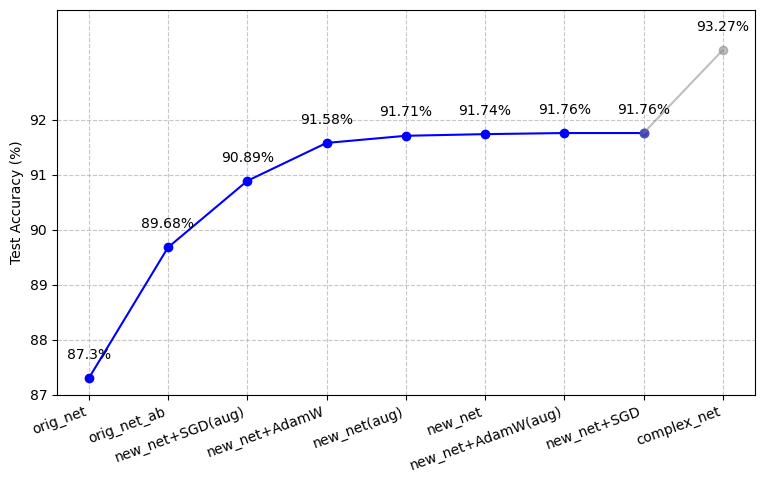

In [168]:
sorted_data = {k: float(v) for k, v in sorted(test_acc.items(), key=lambda x: float(x[1]))}
sort_method = list(sorted_data.keys())
sort_acc = list(sorted_data.values())
plt.figure(figsize=(9,5))
plt.plot(sort_method[:-1], sort_acc[:-1], marker = "o",color = "blue")
plt.plot(sort_method[-2:], sort_acc[-2:], marker = "o",color = "grey", alpha = 0.5)
for m, a in zip(sort_method, sort_acc):
    plt.text(m, a + 0.3, f'{a}%', ha='center', va='bottom', fontsize=10)
plt.ylabel("Test Accuracy (%)")
plt.xticks(rotation=20, ha='right') 
plt.yticks([i for i in range(87,93)]) 
plt.ylim(87, 94)
plt.grid(linestyle='--', alpha=0.7)

**Accuracy with respect to net structure**
(default optimizer: Adam )

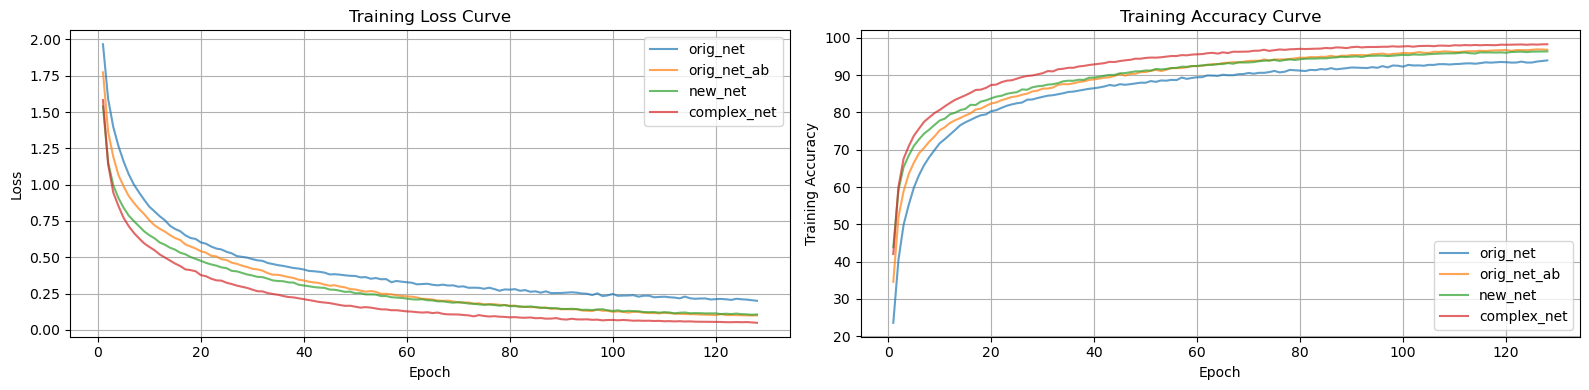

In [ ]:
key = []
for i in keys:
    if "aug" not in i and "+" not in i:
        key.append(i)
plot_train(key)

Text(0, 0.5, 'Test Accuracy (%)')

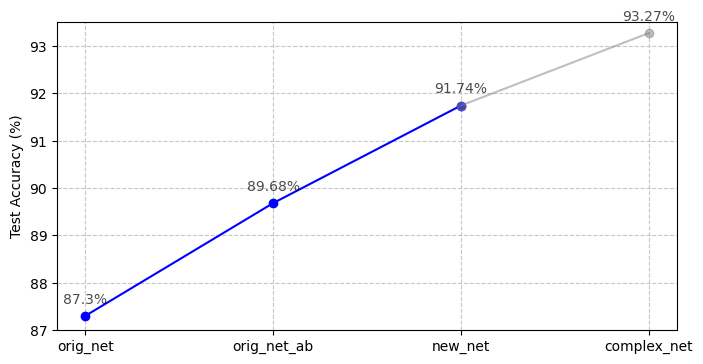

In [ ]:
structure = [i for i in sorted_data.keys() if ("+" not in i) and ("aug" not in i)]
str_acc = [sorted_data[i] for i in sorted_data.keys() if ("+" not in i) and ("aug" not in i)]
plt.figure(figsize=(8,4))
plt.plot(structure[:-1], str_acc[:-1], marker = "o", color = "blue")
plt.plot(structure[-2:], str_acc[-2:], marker = "o", color = "grey", alpha = 0.5)
for m, a in zip(structure, str_acc):
    plt.text(m, a + 0.2, f'{a}%', ha='center', va='bottom', fontsize=10, alpha = 0.7)
plt.ylim(87, 93.5)
plt.grid(linestyle='--', alpha=0.7)
plt.ylabel("Test Accuracy (%)")


**Accuracy with respect to different optimizer/data augmentation**

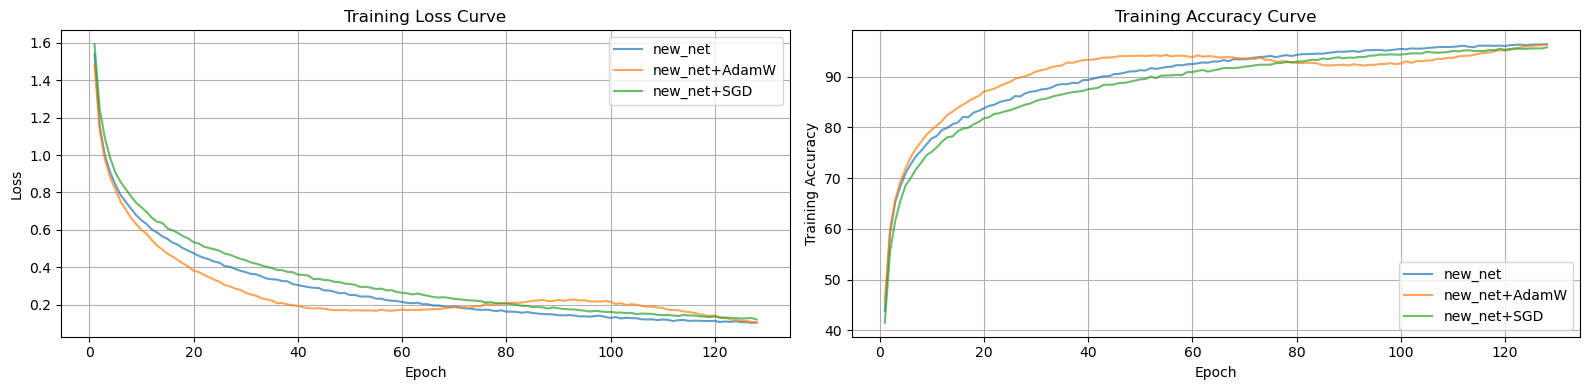

In [186]:
key = []
for i in keys:
    if "aug" not in i and "new_net" in i:
        key.append(i)
plot_train(key)

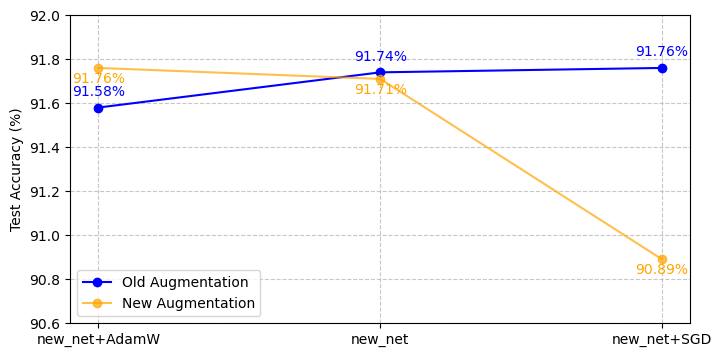

In [184]:
method_name = [i for i in sorted_data.keys() if ("aug" not in i) and ("new" in i)]
no_aug = [sorted_data[i] for i in sorted_data.keys() if ("aug" not in i) and ("new" in i)]
aug = [sorted_data[i+"(aug)"] for i in sorted_data.keys() if ("aug" not in i) and ("new" in i)]
plt.figure(figsize=(8,4))
plt.plot(method_name, no_aug, marker = "o", label='Old Augmentation', color = "blue")
plt.plot(method_name, aug, marker = "o", label='New Augmentation', color='orange',alpha = 0.7)
# plt.hlines(y=91.74, alpha = 0.7,xmin=method_name[0],xmax=method_name[2])
for m, a in zip(method_name, no_aug):
    plt.text(m, a + 0.04, f'{a}%', ha='center', va='bottom', fontsize=10, color='blue')
for m, a in zip(method_name, aug):
    plt.text(m, a - 0.08, f'{a}%', ha='center', va='bottom', fontsize=10, color='orange')
plt.ylabel("Test Accuracy (%)")
plt.yticks([90.6 + 0.2 * i for i in range(10)])
plt.ylim(90.6, 92)
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
